In [1]:
!conda install -y gdown
!pip install torchinfo --quiet
# !pip install https://github.com/ludlows/python-pesq/archive/master.zip

import h5py
import numpy as np
import gdown 
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from torchinfo import summary
# import pesq

Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - gdown


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.10.1               |   py37h89c1867_0         3.1 MB  conda-forge
    filelock-3.0.12            |     pyh9f0ad1d_0          10 KB  conda-forge
    gdown-3.12.2               |     pyh9f0ad1d_0          12 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.1 MB

The following NEW packages will be INSTALLED:

  filelock           conda-forge/noarch::filelock-3.0.12-pyh9f0ad1d_0
  gdown              conda-forge/noarch::gdown-3.12.2-pyh9f0ad1d_0

The following packages will be UPDATED:

  conda                                4.9.2-py37h89c1867_0 --> 4.10.1-py37h89c1867_0



filelock-3.0.12      | 10 KB     | ###################

## Dataset

In [2]:
gdown.download("https://drive.google.com/uc?id=14OubeDRGSioJ7a_Z8-M2pww2pQR3Dy3J", "train_amp.h5")
gdown.download("https://drive.google.com/uc?id=1-6N_f_HQwLo2N1mbewqAYrjca1rDBLpm", "val_amp.h5")
gdown.download("https://drive.google.com/uc?id=1-R1AowBrRCb4tWWe4U3lgINwwTkmy-5x", "test_amp.h5")
gdown.download("https://drive.google.com/uc?id=1-YFvwhwynmYeyczLg9d9-MMU432Yc63E", "test_pha.h5")

Downloading...
From: https://drive.google.com/uc?id=14OubeDRGSioJ7a_Z8-M2pww2pQR3Dy3J
To: /kaggle/working/train_amp.h5
1.30GB [00:10, 123MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1-6N_f_HQwLo2N1mbewqAYrjca1rDBLpm
To: /kaggle/working/val_amp.h5
289MB [00:01, 154MB/s]  
Downloading...
From: https://drive.google.com/uc?id=1-R1AowBrRCb4tWWe4U3lgINwwTkmy-5x
To: /kaggle/working/test_amp.h5
1.55GB [00:13, 111MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1-YFvwhwynmYeyczLg9d9-MMU432Yc63E
To: /kaggle/working/test_pha.h5
324MB [00:02, 152MB/s]  


'test_pha.h5'

In [3]:
hf = h5py.File('train_amp.h5', 'r')
print(hf.keys())
train_amp = np.array(hf.get("train_amp"))
print(train_amp.shape, train_amp.dtype)
train_amp_target = np.array(hf.get("train_amp_target"))
print(train_amp_target.shape, train_amp_target.dtype)
hf.close()

hf = h5py.File('val_amp.h5', 'r')
print(hf.keys())
val_amp = np.array(hf.get("val_amp"))
print(val_amp.shape, val_amp.dtype)
val_amp_target = np.array(hf.get("val_amp_target"))
print(val_amp_target.shape, val_amp_target.dtype)
hf.close()

<KeysViewHDF5 ['train_amp', 'train_amp_target']>
(210000, 129, 11) float32
(210000, 129) float32
<KeysViewHDF5 ['val_amp', 'val_amp_target']>
(46665, 129, 11) float32
(46665, 129) float32


In [4]:
def norm_freq3D(mat):
    # N 129 11
    n, f, t = mat.shape
    for i in range(n):
        for j in range(t):
            mat[i,:, j] = (mat[i,:, j] - np.mean(mat[i,:, j]))/(np.std(mat[i,:, j])+0.001)
    
    return mat

def norm_freq2D(mat):
    # N 129
    n, f = mat.shape
    for i in range(n):
        mat[i,:] = (mat[i,:] - np.mean(mat[i,:]))/(np.std(mat[i,:])+0.001)
    
    return mat

#

def shape_DNN(mat):
    t = norm_freq3D(mat)
#     plt.plot(t[0,:,5])
#     plt.show()

    s = t.shape
    t = np.transpose(t, (0,2,1))
    t = np.reshape(np.ravel(t), (s[0],1,129*11))

#     plt.plot(t[0,0,5*129:6*129])
#     plt.show()
    
    return t

def shape_CNN(mat):
    # ip: n x 129 x 11
    # op: n x 11 x 129 x 1
    t = norm_freq3D(mat) 
    
    s = t.shape
    t = np.transpose(t, (0,2,1))
    t = np.expand_dims(t, 3)
    
    return t

## Select model

In [5]:
model_name = "DNN"

if(model_name == "DNN"):
    # DNN
    train_amp = shape_DNN(train_amp)
    val_amp = shape_DNN(val_amp)

elif(model_name == "CNN"):
    # CNN
    train_amp = shape_CNN(train_amp)
    val_amp = shape_CNN(val_amp)
    
else:
    print("Error")

print(train_amp.shape)

(210000, 1, 1419)


In [6]:
train_amp_target = norm_freq2D(train_amp_target)
val_amp_target = norm_freq2D(val_amp_target)

In [7]:
train_data = TensorDataset(torch.Tensor(train_amp),torch.Tensor(train_amp_target)) 
train_loader = DataLoader(train_data, shuffle = True, batch_size = 512)

val_data = TensorDataset(torch.Tensor(val_amp),torch.Tensor(val_amp_target)) 
val_loader = DataLoader(val_data, batch_size = 512)

## Model architecture

In [8]:

if(model_name == "CNN"):
    
    model = nn.Sequential(
        # Conv2D(input channels, output channels, kernel size, padding, stride)
        nn.Conv2d(11, 52, (5, 1), padding=1, bias=True),
        nn.ReLU(inplace=True),

        nn.MaxPool2d(3),

        nn.Conv2d(52, 78, (5, 1), bias=True),
        nn.ReLU(inplace=True),

        nn.Flatten(),
        nn.Linear(2964, 1024, bias=True),
        nn.ReLU(inplace=True),
        nn.Linear(1024, 1024, bias=True),
        nn.ReLU(inplace=True),
        nn.Linear(1024, 129, bias=True)
    )
    
    print(summary(model, (512, 11, 129,1)))
    

elif(model_name == "DNN"):
    
    model = nn.Sequential(
        nn.Linear(129*11, 1024, bias=True),
        nn.ReLU(inplace=True),

        nn.Linear(1024, 1024, bias=True),
        nn.ReLU(inplace=True),

        nn.Linear(1024, 1024, bias=True),
        nn.ReLU(inplace=True),

        nn.Linear(1024, 1024, bias=True),
        nn.ReLU(inplace=True),

        nn.Linear(1024, 129, bias=True)
    )
    
    print(summary(model, (512, 1, 129*11)))
    
else:
    print("Error")

Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [512, 1, 1024]            1,454,080
├─ReLU: 1-2                              [512, 1, 1024]            --
├─Linear: 1-3                            [512, 1, 1024]            1,049,600
├─ReLU: 1-4                              [512, 1, 1024]            --
├─Linear: 1-5                            [512, 1, 1024]            1,049,600
├─ReLU: 1-6                              [512, 1, 1024]            --
├─Linear: 1-7                            [512, 1, 1024]            1,049,600
├─ReLU: 1-8                              [512, 1, 1024]            --
├─Linear: 1-9                            [512, 1, 129]             132,225
Total params: 4,735,105
Trainable params: 4,735,105
Non-trainable params: 0
Total mult-adds (G): 2.42
Input size (MB): 2.91
Forward/backward pass size (MB): 17.31
Params size (MB): 18.94
Estimated Total Size (MB): 39.15


In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Training + Validation

Epoch: 1 	Train Loss: 327.061652 	Val Loss: 293.785679
Epoch: 5 	Train Loss: 244.395962 	Val Loss: 250.896751
Epoch: 10 	Train Loss: 223.037661 	Val Loss: 219.723836
Epoch: 15 	Train Loss: 210.994943 	Val Loss: 209.997152
Epoch: 20 	Train Loss: 202.703622 	Val Loss: 204.122432
Epoch: 25 	Train Loss: 195.987753 	Val Loss: 200.339646
Epoch: 30 	Train Loss: 189.880263 	Val Loss: 207.088846
Epoch: 35 	Train Loss: 184.708852 	Val Loss: 202.779757
Epoch: 40 	Train Loss: 179.318779 	Val Loss: 206.923060
Epoch: 45 	Train Loss: 174.893388 	Val Loss: 185.143066
Epoch: 50 	Train Loss: 170.418640 	Val Loss: 185.718954


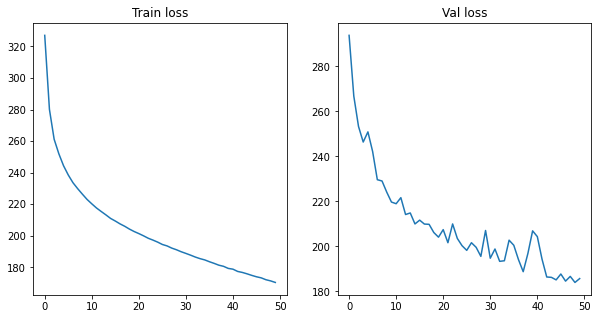

In [10]:
# number of epochs to train the model
n_epochs = 50
model = model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

train_loss_plot=[]
val_loss_plot=[]

for epoch in range(1, n_epochs+1):
    
    # Training
    model.train()
    train_loss = 0.0

    for x,y in train_loader:
        
        if(model_name == "DNN"):
            y=torch.unsqueeze(y,1)
            
        x = x.to(device)
        y = y.to(device)
        
        yhat = model(x)
#         print(yhat.shape, y.shape)
        loss = criterion(yhat, y)
#         print(loss)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # update running training loss
        train_loss += loss.item() * x.size(0)
    
    train_loss = train_loss/len(train_loader)
    train_loss_plot.append(train_loss)
    
    # Validation
    model.eval()
    val_loss = 0.0
    
    for x,y in val_loader:
        
        if(model_name == "DNN"):
            y=torch.unsqueeze(y,1)
            
        x = x.to(device)
        y = y.to(device)
        
        yhat = model(x)
#         print(np.shape(yhat))
        loss = criterion(yhat, y)
        
        val_loss += loss.item() * x.size(0)
        
    val_loss = val_loss/len(val_loader)
    val_loss_plot.append(val_loss) 
        
    # print avg training statistics 
    if(epoch == 1 or epoch%5 == 0):
        print('Epoch: {} \tTrain Loss: {:.6f} \tVal Loss: {:.6f}'.format(
        epoch, train_loss, val_loss
        ))

plt.figure(figsize=(10,5))        
plt.subplot(121)
plt.plot(train_loss_plot)
# plt.xlim(left=0)
# plt.ylim(bottom=0)
plt.title("Train loss")

plt.subplot(122)
plt.plot(val_loss_plot)
# plt.xlim(left=0)
# plt.ylim(bottom=0)
plt.title("Val loss")
plt.show()

## Testing

In [13]:
import librosa
import numpy as np
import soundfile
import IPython.display as ipd
import os
import shutil

def get_mean_std(mat):
    n, f, t = mat.shape
    
    m = np.zeros(n)
    std = np.zeros(n)
    
    for i in range(n):
        m[i] = np.median(mat[i,:,5])
        std[i] = np.std(mat[i,:,5])
    
    return m, std

def get_test2D(mat):
    n, f, t = mat.shape
    
    out = np.zeros((n, f))
    
    for i in range(n):
        out[i,:] = mat[i,:,5]
    
    return out

def multiply_mean_std(mat, m, std):
    n, f = mat.shape
    
    for i in range(n):
        mat[i,:] = (mat[i,:] * (std[i] + 0.001)) + m[i]
    
    return mat


def magnitude_db_and_phase_to_audio(frame_length, hop_length_fft, stftaudio_magnitude_db, stftaudio_phase):
    """This functions reverts a spectrogram to an audio"""

    stftaudio_magnitude_rev = librosa.db_to_amplitude(stftaudio_magnitude_db, ref=1.0)

    # taking magnitude and phase of audio
    audio_reverse_stft = stftaudio_magnitude_rev * stftaudio_phase
    audio_reconstruct = librosa.core.istft(audio_reverse_stft, hop_length=hop_length_fft, length=frame_length)

    return audio_reconstruct

def matrix_spectrogram_to_numpy_audio(m_mag_db, m_phase, frame_length, hop_length_fft)  :
    """This functions reverts the matrix spectrograms to numpy audio"""

    list_audio = []

    nb_spec = m_mag_db.shape[0]

    for i in range(nb_spec):

        audio_reconstruct = magnitude_db_and_phase_to_audio(frame_length, hop_length_fft, m_mag_db[i], m_phase[i])
        list_audio.append(audio_reconstruct)

    return np.vstack(list_audio)

def get_time_series(amp, pha):
    s=amp.shape
    dim1 = 129
    dim2 = 64
    nb=int(s[0]/dim2)

    amp=np.reshape(amp[:nb*dim2,:],(nb,dim2,dim1))
    amp=np.transpose(amp,(0,2,1))

    pha=np.reshape(pha[:nb*dim2,:],(nb,dim2,dim1))
    pha=np.transpose(pha,(0,2,1))

    print(amp.shape)
    print(pha.shape)
    
    frame_length = 8084
    hop_length_fft = 128

    audio_denoise_recons = matrix_spectrogram_to_numpy_audio(amp, pha, frame_length, hop_length_fft)

    #Number of frames
    nb_samples = audio_denoise_recons.shape[0]

    #Save all frames in one file
    denoise_long = audio_denoise_recons.reshape(1, nb_samples * frame_length)
    out = denoise_long[0, :]
    
    return out


0
(701, 129, 64)
(701, 129, 64)
(701, 129, 64)
(701, 129, 64)
(701, 129, 64)
(701, 129, 64)


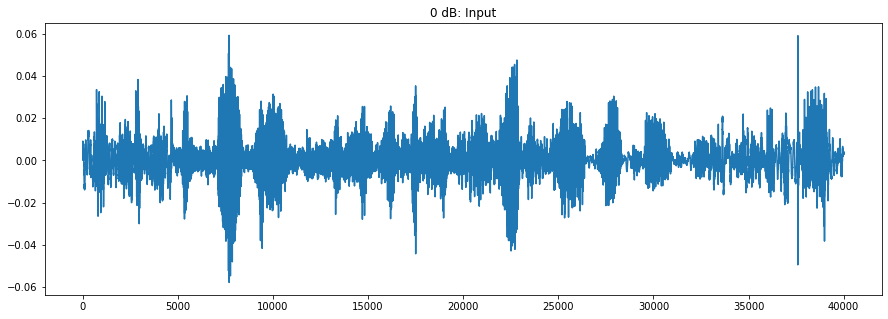

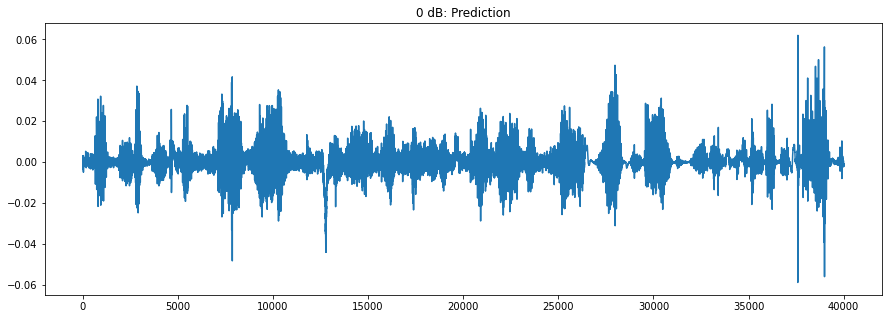

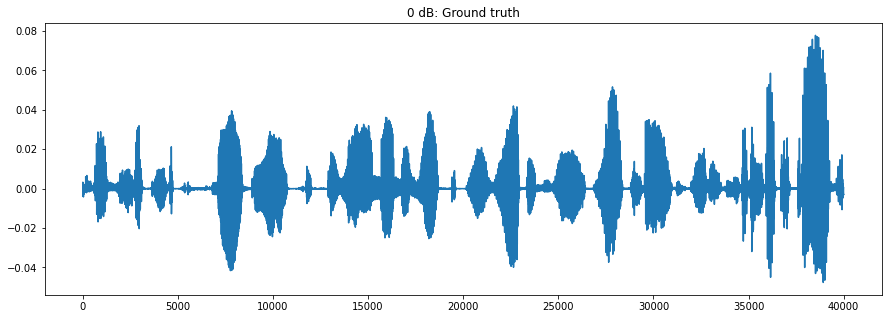

5
(701, 129, 64)
(701, 129, 64)
(701, 129, 64)
(701, 129, 64)
(701, 129, 64)
(701, 129, 64)


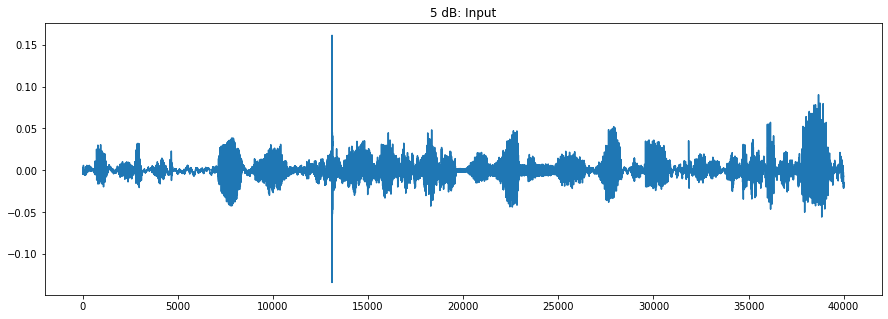

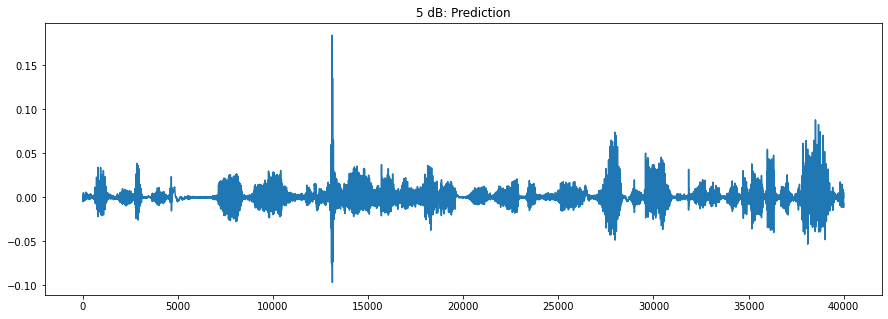

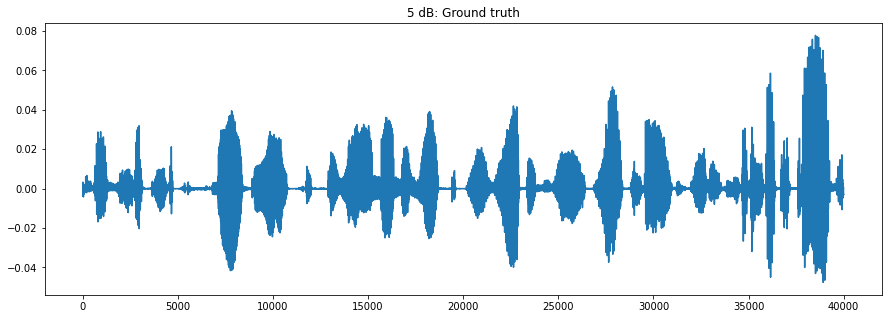

10
(701, 129, 64)
(701, 129, 64)
(701, 129, 64)
(701, 129, 64)
(701, 129, 64)
(701, 129, 64)


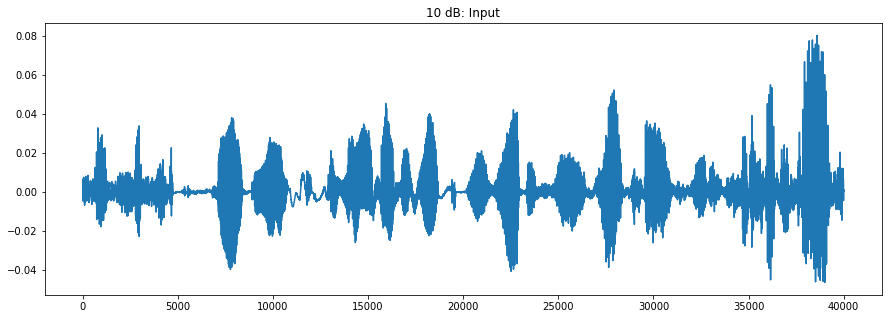

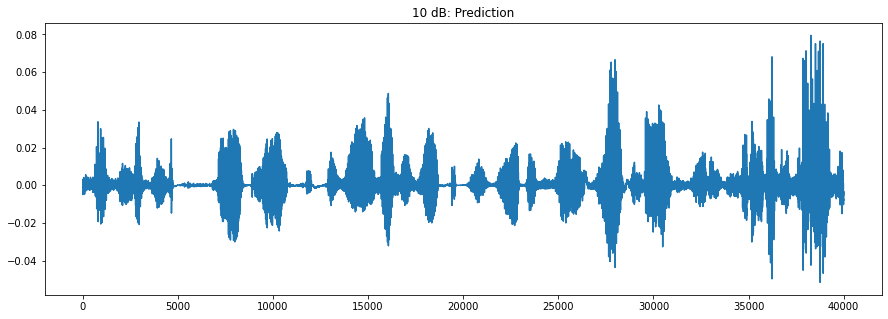

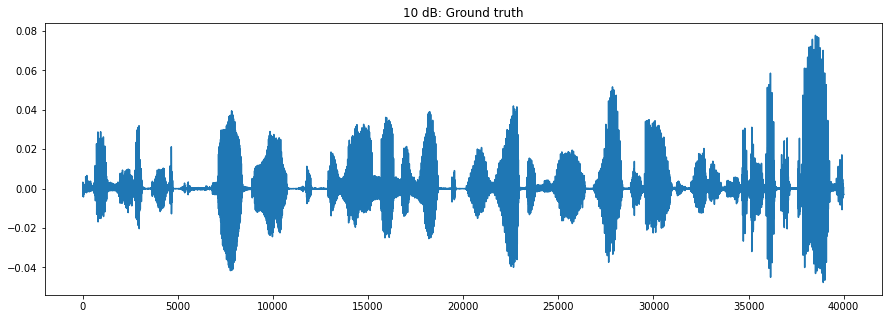

2
(701, 129, 64)
(701, 129, 64)
(701, 129, 64)
(701, 129, 64)
(701, 129, 64)
(701, 129, 64)


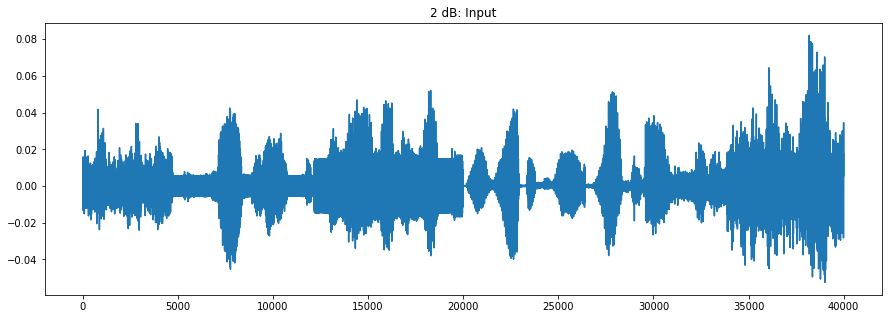

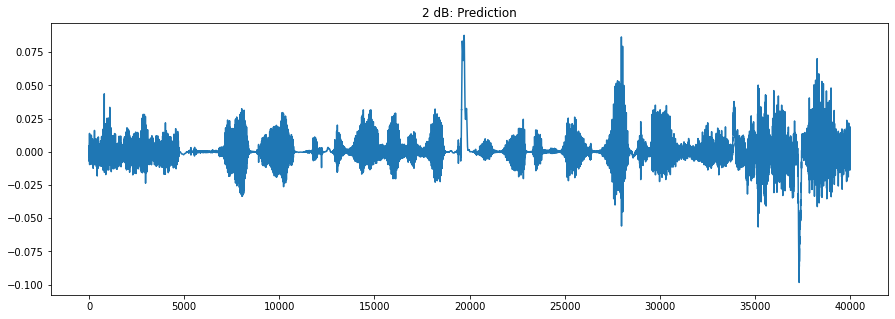

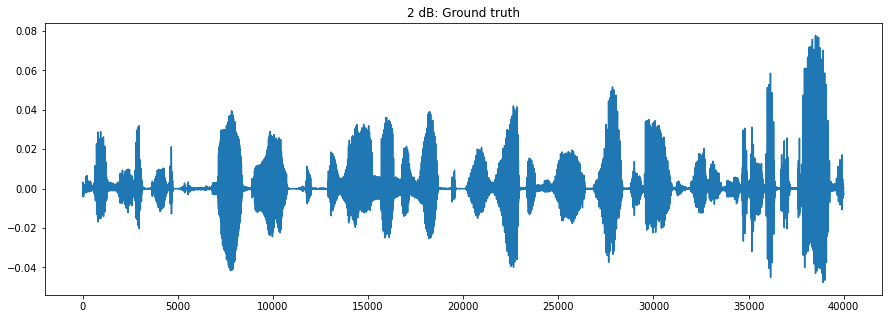

7
(701, 129, 64)
(701, 129, 64)
(701, 129, 64)
(701, 129, 64)
(701, 129, 64)
(701, 129, 64)


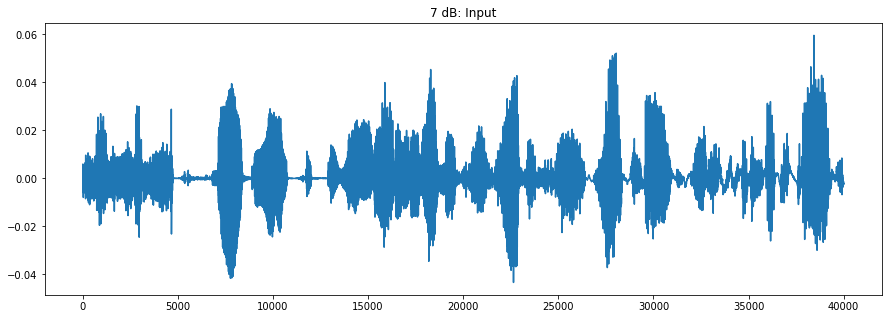

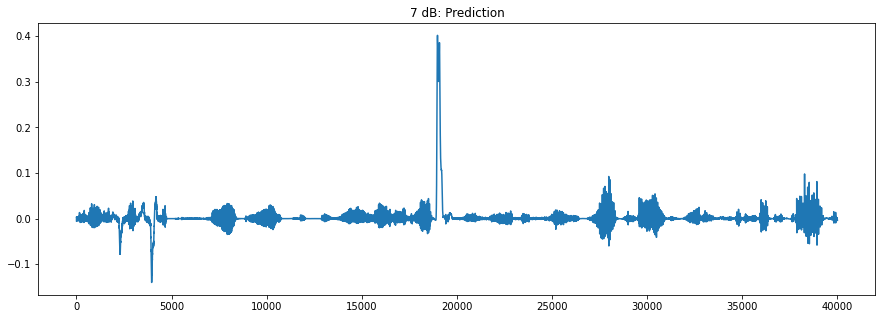

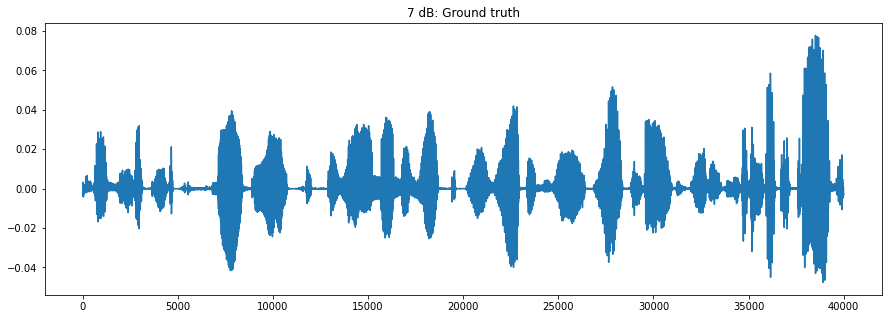

n3
(701, 129, 64)
(701, 129, 64)
(701, 129, 64)
(701, 129, 64)
(701, 129, 64)
(701, 129, 64)


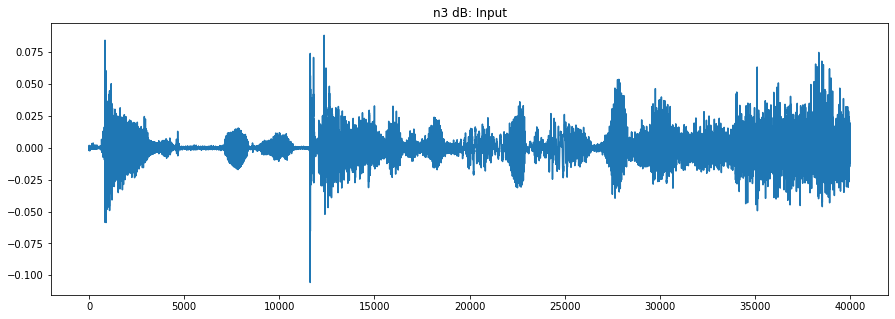

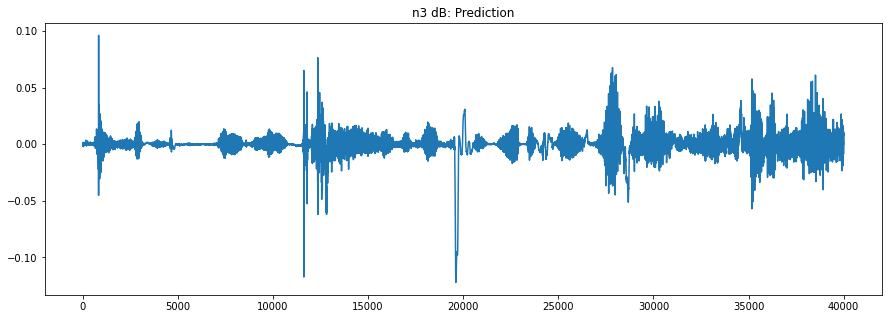

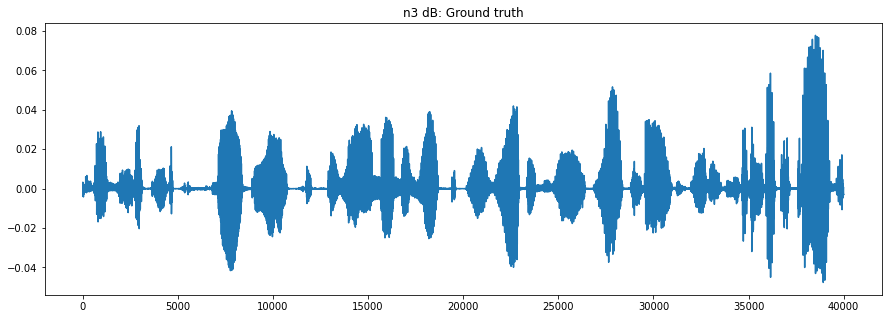

In [14]:
if not os.path.exists("save"):
    os.makedirs("save")

for SNR in ["0","5","10","2","7","n3"]: # Edit  ["0","5","10","2","7","n3"]
    
    print(SNR)
    
    hf = h5py.File('test_amp.h5', 'r')
#     print(hf.keys())
    test_amp = np.array(hf.get("test_amp_" + SNR)) 
#     print(test_amp.shape, test_amp.dtype)
    test_amp_target = np.array(hf.get("test_amp_target"))
#     print(test_amp_target.shape, test_amp_target.dtype)
    hf.close()

    hf = h5py.File('test_pha.h5', 'r')
#     print(hf.keys())
    test_pha = np.array(hf.get("test_pha_" + SNR)) 
#     print(test_pha.shape, test_pha.dtype)
    test_pha_target = np.array(hf.get("test_pha_target"))
#     print(test_pha_target.shape, test_pha_target.dtype)
    hf.close()

    test_in = get_test2D(test_amp)     
    test_mean, test_std = get_mean_std(test_amp)
    
    if(model_name == "DNN"):
        # DNN
        test_amp = shape_DNN(test_amp)
    elif(model_name == "CNN"):
        # CNN
        test_amp = shape_CNN(test_amp)
    else:
        print("Error")

    test_data = TensorDataset(torch.Tensor(test_amp),torch.Tensor(test_amp_target)) 
    test_loader = DataLoader(test_data, batch_size = 512)
    
    ## Predict
    pred = []

    with torch.no_grad():
        for x,y in test_loader:
            x = x.to(device)
    #             y = y.to(device)
            yhat = model(x)
        
            if(model_name == "DNN"):
                yhat = torch.squeeze(yhat)
    #         print(np.shape(yhat))
            pred.append(yhat.cpu().detach().numpy())

    pred = np.vstack(pred)

    pred = multiply_mean_std(pred, test_mean, test_std)

    ## Reconstruct

    test_out = get_time_series(pred, test_pha)
    test_target_out = get_time_series(test_amp_target, test_pha_target)
    test_in_ts = get_time_series(test_in, test_pha)

    ## Save
    fs = 8000
    soundfile.write("save/test_out_" + SNR + "_dB.wav", test_out, fs)
    soundfile.write("save/test_target_out_" + SNR + "_dB.wav", test_target_out, fs)
    soundfile.write("save/test_in_" + SNR + "_dB.wav", test_in_ts, fs)
    
#     np.save("save/test_out_" + SNR + "_dB", pred)
#     np.save("save/test_target_out_" + SNR + "_dB", test_amp_target)
#     np.save("save/test_in_" + SNR + "_dB", test_in)
    
    ## Plot sample
    plt.figure(figsize=(15,5))
    plt.plot(test_in_ts[40000: 80000])
    plt.title(SNR + " dB: Input")
    plt.show()

    plt.figure(figsize=(15,5))
    plt.plot(test_out[40000: 80000])
    plt.title(SNR + " dB: Prediction")
    plt.show()

    plt.figure(figsize=(15,5))
    plt.plot(test_target_out[40000: 80000])
    plt.title(SNR + " dB: Ground truth")
    plt.show()

In [ ]:
shutil.make_archive("save_" + model_name, 'zip', "save")

In [ ]:
# shutil.rmtree("save")

In [1]:
# SNR = "0"
# ipd.Audio("save/test_out_" + SNR + "_dB.wav", rate = fs)

In [2]:
# ipd.Audio("save/test_in_" + SNR + "_dB.wav", rate = fs)